In [1]:
import random
from pathlib import Path
from typing import List

import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from PIL import Image
from torchvision.models import get_model
from torchvision.transforms.v2 import (
    Compose,
    Resize,
    ToDtype,
    ToImage,
    Normalize,
    ColorJitter, 
    RandomHorizontalFlip,
    RandomResizedCrop,
    RandomGrayscale,
    GaussianBlur,
)
from torch.nn import Module, Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy, MeanMetric

In [2]:
DATASET_PATH = Path("/kaggle/input/recyclable-and-household-waste-classification")
MEAN = [0.47028565, 0.4600675 , 0.4550754]
STD = [0.26398006, 0.26271883, 0.26737422]
IMAGE_SIZE = 256

In [3]:
class WasteDataset(Dataset):
    def __init__(self, images: List[Image.Image], labels: List[int], augment: bool = False) -> None:
        self.augment = augment
        self.augment_transform = Compose(
            [
                ToImage(),
                RandomResizedCrop(size=(IMAGE_SIZE, IMAGE_SIZE), scale=(0.3, 1.0), antialias=True),
                ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), 
                RandomHorizontalFlip(),
                RandomGrayscale(),
                GaussianBlur(kernel_size=3),
                ToDtype(torch.float32, scale=True),
                Normalize(mean=MEAN, std=STD),
            ]
        )
        self.transform = Compose(
            [
                ToImage(),
                Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=False),
                ToDtype(torch.float32, scale=True),
                Normalize(mean=MEAN, std=STD),
            ]
        )
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        if self.augment:
            image = self.augment_transform(image)
        else:
            image = self.transform(image)
        return image, torch.tensor(self.labels[index], dtype=torch.int64)

In [4]:
class WasteTrainer:
    def __init__(
        self,
        model: Module,
        criterion: CrossEntropyLoss,
        optimizer: Adam,
        num_classes: int,
        device: str,
    ) -> None:
        self.device = device
        self.model = model.to(device)
        self.criterion = criterion.to(device)
        self.optimizer = optimizer
        
        self.accuracy = Accuracy(
            task="multiclass", num_classes=num_classes, top_k=1
        ).to(device)
        self.train_loss = MeanMetric().to(device)
        self.train_accuracy = MeanMetric().to(device)
        self.val_loss = MeanMetric().to(device)
        self.val_accuracy = MeanMetric().to(device)
        
    def fit(
        self,
        train_dataset: WasteDataset,
        val_dataset: WasteDataset,
        batch_size: int,
        epochs: int,
        verbose: bool = False,
    ) -> None:
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True
        )
        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False
        )
        
        for epoch in range(1, epochs + 1):
            print(f"Epoch {epoch}/{epochs}:")
            
            self._train_one_epoch(train_loader, verbose=verbose)
            self._validate_one_epoch(val_loader, verbose=verbose)
            
            print(
                f"loss {self.train_loss.compute():.4f} - "
                f"accuracy {self.train_accuracy.compute():.4f} - "
                f"val loss {self.val_loss.compute():.4f} - "
                f"val accuracy {self.val_accuracy.compute():.4f}"
            )
            
            for metric in (self.train_loss, self.train_accuracy, self.val_loss, self.val_accuracy):
                metric.reset()
    
    def _train_one_epoch(self, loader: DataLoader, verbose: bool) -> None:
        self.model.train()
        
        with tqdm(total=len(loader), desc="Training", disable=not verbose) as progress_bar:
            for batch in loader:
                images = batch[0].to(device)
                labels = batch[1].to(device)

                self.optimizer.zero_grad()
                logits = self.model(images)
                loss = self.criterion(logits, labels)
                loss.backward()
                self.optimizer.step()

                self.train_loss.update(loss.item())
                self.train_accuracy.update(self.accuracy(logits, labels))
                mean_loss = self.train_loss.compute()
                mean_accuracy = self.train_accuracy.compute()
                progress_bar.set_description(f"loss {mean_loss:.4f} - accuracy {mean_accuracy:.4f}")
                progress_bar.update()
    
    def _validate_one_epoch(self, loader: DataLoader, verbose: bool) -> None:
        self.model.eval()
        
        with torch.no_grad(), tqdm(total=len(loader), disable=not verbose) as progress_bar:
            for batch in loader:
                images = batch[0].to(device)
                labels = batch[1].to(device)

                logits = self.model(images)
                loss = self.criterion(logits, labels)
                
                self.val_loss.update(loss.item())
                self.val_accuracy.update(self.accuracy(logits, labels))
                mean_loss = self.val_loss.compute()
                mean_accuracy = self.val_accuracy.compute()
                progress_bar.set_description(f"loss {mean_loss:.4f} - accuracy {mean_accuracy:.4f}")
                progress_bar.update()

In [5]:
image_paths = list(DATASET_PATH.rglob("*.png"))

In [6]:
labels = list({x.parents[1].name for x in image_paths})

In [7]:
labels

['styrofoam_food_containers',
 'aluminum_food_cans',
 'plastic_shopping_bags',
 'steel_food_cans',
 'aluminum_soda_cans',
 'coffee_grounds',
 'disposable_plastic_cutlery',
 'newspaper',
 'aerosol_cans',
 'paper_cups',
 'office_paper',
 'plastic_soda_bottles',
 'plastic_trash_bags',
 'cardboard_packaging',
 'eggshells',
 'plastic_straws',
 'cardboard_boxes',
 'styrofoam_cups',
 'shoes',
 'plastic_detergent_bottles',
 'plastic_food_containers',
 'tea_bags',
 'magazines',
 'food_waste',
 'glass_food_jars',
 'glass_beverage_bottles',
 'plastic_cup_lids',
 'plastic_water_bottles',
 'glass_cosmetic_containers',
 'clothing']

In [8]:
label_map = {x: i for i, x in enumerate(labels)}
label_map

{'styrofoam_food_containers': 0,
 'aluminum_food_cans': 1,
 'plastic_shopping_bags': 2,
 'steel_food_cans': 3,
 'aluminum_soda_cans': 4,
 'coffee_grounds': 5,
 'disposable_plastic_cutlery': 6,
 'newspaper': 7,
 'aerosol_cans': 8,
 'paper_cups': 9,
 'office_paper': 10,
 'plastic_soda_bottles': 11,
 'plastic_trash_bags': 12,
 'cardboard_packaging': 13,
 'eggshells': 14,
 'plastic_straws': 15,
 'cardboard_boxes': 16,
 'styrofoam_cups': 17,
 'shoes': 18,
 'plastic_detergent_bottles': 19,
 'plastic_food_containers': 20,
 'tea_bags': 21,
 'magazines': 22,
 'food_waste': 23,
 'glass_food_jars': 24,
 'glass_beverage_bottles': 25,
 'plastic_cup_lids': 26,
 'plastic_water_bottles': 27,
 'glass_cosmetic_containers': 28,
 'clothing': 29}

In [9]:
train_image_paths, val_image_paths = train_test_split(
    image_paths, test_size=0.2, shuffle=True
)

In [10]:
train_images = [
    Image.open(x).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE))
    for x in tqdm(train_image_paths)
]

  0%|          | 0/12000 [00:00<?, ?it/s]

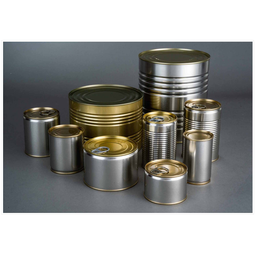

In [11]:
train_images[1]

In [12]:
val_images = [
    Image.open(x).convert("RGB").resize((IMAGE_SIZE, IMAGE_SIZE))
    for x in tqdm(val_image_paths)
]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [13]:
train_labels = [label_map[x.parents[1].name] for x in train_image_paths]
val_labels = [label_map[x.parents[1].name] for x in val_image_paths]

In [14]:
train_labels[1]

1

In [15]:
train_dataset = WasteDataset(train_images, train_labels, augment=True)
val_dataset = WasteDataset(val_images, val_labels)

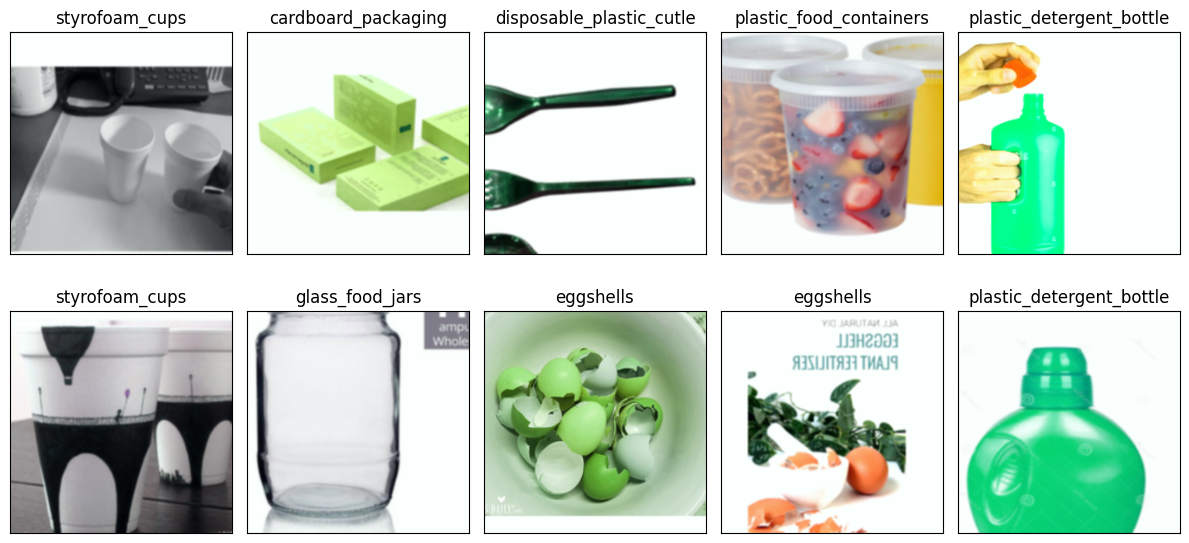

In [16]:
figure, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
axes = axes.flatten()

for ax in axes:
    index = random.randint(0, len(train_dataset) - 1)
    image, target = train_dataset[index]
    image = image.numpy().transpose(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())
    ax.imshow(image)
    ax.set_title(labels[target.item()][:24])
    ax.set_xticks([])
    ax.set_yticks([])
    
figure.tight_layout()

In [17]:
device = "cuda"
model = get_model("efficientnet_v2_s", weights="DEFAULT")
model

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 133MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [18]:
model.classifier[1] = Linear(in_features=1280, out_features=len(labels))
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters())
trainer = WasteTrainer(model=model, criterion=criterion, optimizer=optimizer, num_classes=len(labels), device=device)
trainer.fit(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=32,
    epochs=30,
    verbose=True,
)
torch.save(model.state_dict(), "model.pt")

Epoch 1/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 1.4180 - accuracy 0.5840 - val loss 1.1538 - val accuracy 0.6600
Epoch 2/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.9367 - accuracy 0.7104 - val loss 0.8107 - val accuracy 0.7473
Epoch 3/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.7924 - accuracy 0.7441 - val loss 0.7023 - val accuracy 0.7775
Epoch 4/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.6939 - accuracy 0.7736 - val loss 0.6475 - val accuracy 0.8003
Epoch 5/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.6375 - accuracy 0.7913 - val loss 0.6605 - val accuracy 0.7963
Epoch 6/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.5787 - accuracy 0.8068 - val loss 0.6626 - val accuracy 0.7928
Epoch 7/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.5329 - accuracy 0.8188 - val loss 0.6236 - val accuracy 0.8047
Epoch 8/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.5048 - accuracy 0.8310 - val loss 0.6237 - val accuracy 0.8073
Epoch 9/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.4732 - accuracy 0.8389 - val loss 0.6532 - val accuracy 0.8087
Epoch 10/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.4513 - accuracy 0.8489 - val loss 0.6057 - val accuracy 0.8225
Epoch 11/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.4335 - accuracy 0.8549 - val loss 0.6461 - val accuracy 0.8149
Epoch 12/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.4067 - accuracy 0.8633 - val loss 0.6485 - val accuracy 0.8156
Epoch 13/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.4021 - accuracy 0.8628 - val loss 0.5940 - val accuracy 0.8191
Epoch 14/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.3759 - accuracy 0.8723 - val loss 0.6112 - val accuracy 0.8261
Epoch 15/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.3559 - accuracy 0.8740 - val loss 0.6495 - val accuracy 0.8146
Epoch 16/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.3495 - accuracy 0.8765 - val loss 0.6295 - val accuracy 0.8251
Epoch 17/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.3482 - accuracy 0.8766 - val loss 0.6179 - val accuracy 0.8298
Epoch 18/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.3307 - accuracy 0.8838 - val loss 0.6654 - val accuracy 0.8185
Epoch 19/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.3218 - accuracy 0.8883 - val loss 0.6063 - val accuracy 0.8231
Epoch 20/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.3055 - accuracy 0.8898 - val loss 0.6030 - val accuracy 0.8361
Epoch 21/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.3046 - accuracy 0.8943 - val loss 0.6789 - val accuracy 0.8225
Epoch 22/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.2825 - accuracy 0.8962 - val loss 0.6540 - val accuracy 0.8224
Epoch 23/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.2881 - accuracy 0.8958 - val loss 0.5913 - val accuracy 0.8408
Epoch 24/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.2695 - accuracy 0.9038 - val loss 0.6393 - val accuracy 0.8265
Epoch 25/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.2707 - accuracy 0.9041 - val loss 0.6285 - val accuracy 0.8323
Epoch 26/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.2526 - accuracy 0.9077 - val loss 0.7154 - val accuracy 0.8191
Epoch 27/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.2588 - accuracy 0.9070 - val loss 0.6573 - val accuracy 0.8164
Epoch 28/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.2434 - accuracy 0.9129 - val loss 0.6749 - val accuracy 0.8267
Epoch 29/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.2558 - accuracy 0.9088 - val loss 0.6716 - val accuracy 0.8218
Epoch 30/30:


Training:   0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

loss 0.2453 - accuracy 0.9116 - val loss 0.6405 - val accuracy 0.8311


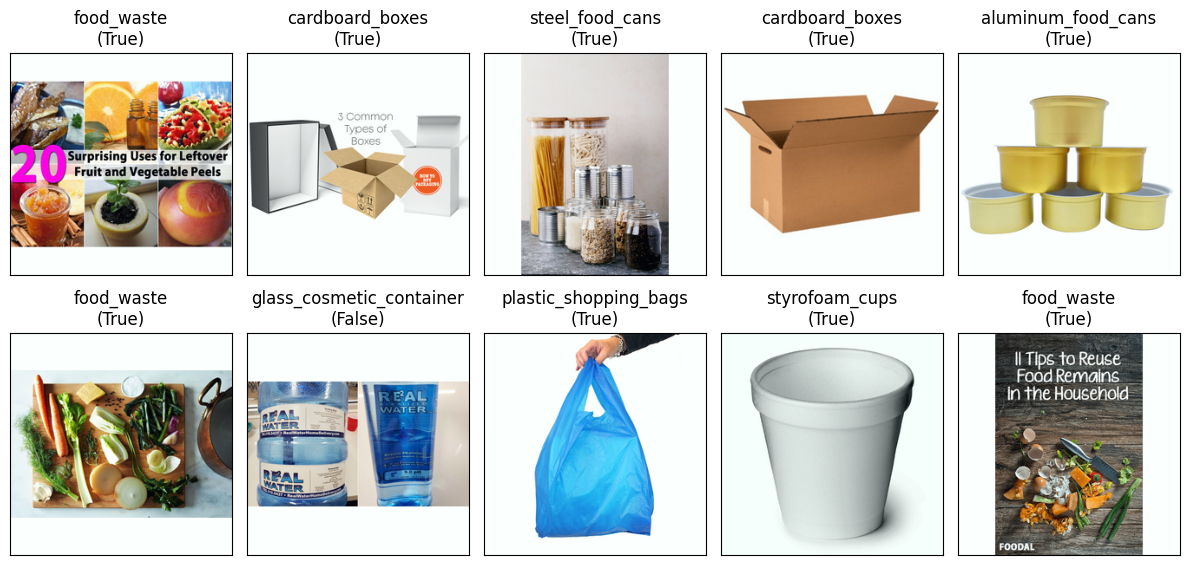

In [19]:
figure, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
axes = axes.flatten()
model.eval()

for ax in axes:
    index = random.randint(0, len(val_dataset) - 1)
    
    image, label = val_dataset[index]
    predict = model(image.to("cuda").unsqueeze(0))[0].argmax().item()
    correct = predict == label.item()
    
    image = image.numpy().transpose(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())
    
    ax.imshow(image)
    ax.set_title(f"{labels[predict][:24]}\n({correct})")
    ax.set_xticks([])
    ax.set_yticks([])
    
figure.tight_layout()
figure.show()